# MLonMCU

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tum-ei-eda/mlonmcu/blob/main/ipynb/Demo.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tum-ei-eda/mlonmcu/blob/main/ipynb/Demo.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
</table>

## Prerequisites

Before running this notebook, make sure to run the following steps:

1. Install the required software for your distribution:

   See main `README.md` file!
   
2. Clone this repository

   ```
   git clone https://github.com/tum-ei-eda/mlonmcu.git
   cd mlonmcu  # enter cloned repository
   ```
   
3. Setup and enter a new virtualenv (Python 3.7+) for using `mlonmcu`:

   ```
   python -m venv .venv
   source .venv/bin/activate
   ```
   
   Hint: You can also use a `conda` environment for this.
   
4. Install mlonmcu package

   ```
   make install  # alternative: python setup.py install
   ```
   
5. Install the required python packages:

   ``` 
   # pip install -r requirements.txt  # Done automatically via setup.py?
   pip install -r ipynb/requirements.txt
   ```
   
6. Launch this notebook in jupyter:

   ```
   jupyter notebook ipynb/Demo.ipynb
   ```

*Hint for Developers:* If you do not want to install MLonMCU first, you can just replace `mlonmcu` with `python -m mlonmcu.cli.main` in every command to just use the latest development version.

## Demonstration (Command Line)

### Preface

This guide should give an idea on the required steps to setup and use MLonMCU using the command line interface. Usage examples are provided as well.

### Initialize a MLonMCU environment

As MLonMCU requires a directory where dependencies, configurations, intermediate artifacts and results are stored, an environment needs to be initialized first. This also allows to use different configuration (e.g. enabled backends or supported features) for multiple environments.

Create and enter an environment diretcory first to initialize it afterwards:

In [1]:
# WARNING: execute this only once! Alternatively remove the environment directory beforehand to start from scratch.
!test -d /tmp/mlonmcu_env && echo "Skipped initialization of environment" \
  || mlonmcu init /tmp/mlonmcu_env --non-interactive

Initializing ML on MCU environment
Selected target directory: /tmp/mlonmcu_env
The directory does not exist! - Created directory.
Creating environment.yml based on template 'default'.
Skipping creation of virtual environment. (already inside one)
Initializing directories in environment: deps plugins
Finished. Please add `export MLONMCU_HOME=/tmp/mlonmcu_env` to your shell configuration to use it anywhere
Recommended next step: `mlonmcu setup` inside your virtual environment.
Optional: `mlonmcu setup -g`


When not using a notebook, the option `--non-interactive` can be omitted which allows to customize the initialization process interactively.

If the environment directory is not passed to the `mlonmcu` script, it will try to setup a `default` environment in the users home directory (On Ubuntu: `~/.config/mlonmcu/environments/default/`) instead. By providing a `--name` of the virtual environment if will be automatically registered in `~/.config/mlonmcy/environments.ini` for the current user which helps to find and distinguish multiple installed environments on a machine.

In the following the actual environment which should be used by the `mlonmcu` program has to be defined by the user either by defining the environment variable `MLONMCU_HOME` or by using the `-H` (`--home` or `--hint`) command line option. If none of this was done, the following rules are following to look for a suitable environment:

1. Check if `$MLONMCU_HOME` points to a valid environment
2. Use environment provided via the `-H` flag (path or registered name) if available
3. If the local working directory is the root of an environment, use this directory
4. If there is a default environment for the current user, fall back to this one instead

In [2]:
# Use this for bash: `export MLONMCU_HOME=/tmp/mlonmcu_env`
%env MLONMCU_HOME=/tmp/mlonmcu_env

env: MLONMCU_HOME=/tmp/mlonmcu_env


Registered environment can be listed via the command `mlonmcu env`. In addition there are possibilities to manually update entires in the environments file.

In [3]:
!mlonmcu env

Looking for user environments config file: /home/ga87puy/.config/mlonmcu/environments.ini
Found 3 mlonmcu environment(s):
    - default (/home/ga87puy/.config/mlonmcu/environments/default)
    - unnamed (/nfs/TUEIEDAscratch/ga87puy/mlonmcu_research)
    - unnamed_0 (/tmp/vankempen/mlonmcu/workspace)
Point the environment variable MLONMCU_HOME to a environment directory to get started


### Customizing the created MLonMCU environment (optional)

The environment was initialized by a template which can be found in the `templates/` directory of the repository chosen via the `--template` flag. Lets inspect the generated configuration file first:

In [4]:
!cat $MLONMCU_HOME/environment.yml

---
# The MLONMCU_HOME is filled in automatically when creating the environment
home: "/tmp/mlonmcu_env"
logging:
  level: DEBUG
  to_file: false
  rotate: false
cleanup:
  auto: true
  keep: 50
# Default locations for certain directoriescan be changed here
# Non-absolute paths will always be threated relative to the MLONMCU_HOME
paths:
  # Where the dependencies are downloaded and installed
  deps: deps
  # If logging to file is used keep logs in this directory
  logs: logs
  # Location where reports and artifacts are written to
  results: results
  # Directory where custom extensions can be integrated
  plugins: plugins
  # Directory for intermediate build products, should be located on a large enough drive
  temp: temp
  # A collection of models which will be used to look for models
  # The paths will be checked in the order defined here stopping at the first match
  # Non-existant paths will be skipped without throwing an error
  models:
    - "/tmp/mlonmcu_env/models"
    - "/home

The environment should work out of the box, but feel free to update the contents of the `environment.yml` file to achieve one of the following:

- Change the default paths used for dependencies, results, models,...
- Use different forks/versions of a repository
- Disable certain frameworks/backends to reduce the installation time in the next step.
- Define which features are supported for the given repositories
- Set default backends and targets
- Define a set of default configuration variables

To learn more about this, check out this document: `ENVIRONMENTS.md`

### Setting up all MLonMCU dependencies

Depending on the enabled backends and features, a different set of dependencies has to be installed. To reduce the management effort for the user, all these versions are installed and managed automatically using MLonMCU. To trigger this process, run the following in the command line. (This will take a very long time with all frameworks/targets/features enabled when invoked for the first time)

In [5]:
!mlonmcu setup

INFO - No cache found in deps directory
INFO - Loading extensions.py (User)
INFO - Installing dependencies...
INFO - Processing task: install_riscv_gcc{'pext': False, 'vext': False}
INFO - Processing task: install_arm_gcc
INFO - Processing task: clone_cmsis
INFO - Processing task: clone_espidf
INFO - Processing task: clone_etiss
INFO - Processing task: clone_muriscvnn
INFO - Processing task: clone_spike_pk
INFO - Processing task: clone_spike
INFO - Processing task: clone_tensorflow
INFO - Processing task: clone_tflite_micro_compiler
INFO - Processing task: clone_tvm_extensions
INFO - Processing task: install_llvm
INFO - Processing task: clone_utvm_staticrt_codegen
INFO - Processing task: clone_pulp_freertos
INFO - Processing task: install_corstone300
INFO - Processing task: clone_microtvm_etissvp
INFO - Processing task: clone_mlif
INFO - Processing task: download_tflite_vizualize
INFO - Processing task: install_zephyr
INFO - Processing task: install_pulp_gcc
INFO - Processing task: bui

Some things need to be considered here:
- Repositories are only cloned once, so upstream changes or updated urls/branches in the `environments.yml` are not detected automatically
- The flag `--rebuild` can be passed to `mlonmcu setup` to ensure that the setup routine of every dependency is triggered again. However this does not guarentee that all artifacts are properly updated. Also there is a `--task` option which allows to invoke individual tasks manually.
- To guarantee that the latest versions of a dependency are installed you can remove the `deps` directory manually or alternative use the provided `mlonmcu cleanup` utility. (Execute `mlonmcu cleanup --help` to learn more)
- In addition to the installed dependencies, a file named `cache.ini` can be found in the environments `deps/` directory. Here all paths to relevant dependencies are stored with their different sets of flags.

### Adding models to MLonMCU

By default, the `mlonmcu-models` repository (https://github.com/tum-ei-eda/mlonmcu-models) is cloned to each environment as its contents are designed to perfectly integrate into the MLonMCU flow. In addition a location in the users home directory (`~/.config/mlonmcu/models/` for Ubuntu) is also added to the search path as defined in the `environments.yml`. Feel free to add further model manually or alternatively clone a model-zoo (e.g. https://github.com/ARM-software/ML-zoo) to a random location on the disc and updating the list of model-paths in the environments' config file.

To list all available models in a environment, the `mlonmcu models` subcommand can be used:

In [6]:
!mlonmcu models

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
Models Summary

Paths:
    /tmp/mlonmcu_env/models
    /nas/ei/home/ga87puy/.config/mlonmcu/models

Models:
    MobileNetV2
    MobileNetV2/MobileNet_V2
    aww
    bigsine_quant
    catdog
    catdog/CNN_2L_model_quantized
    catdog/CNN_full_quantized
    catdog/CNN_full_quantized_70_
    catdog/CNN_model
    catdog2
    cifar10
    cnn_s_quantized
    lstm2
    magic_wand
    micro_speech (1 duplicates)
    micro_speech_custom
    micro_speech_custom_lr
    micro_speech_custom_ud
    micro_speech_ds_cnn_s_15000_2w
    micro_speech_ds_cnn_s_15000_4w
    micro_speech_micro_speech_15000_2w
    micro_speech_micro_speech_15000_4w
    mobilenet_v1_0_25_128
    mobilenet_v1_10_224
    mobilenet_v1_1_0_224_quant
    mobilenetv1
    person_detect
    resnet
    simple_mnist
    simple_mnist/MNIST_best_model
    simple_mnist/MNIST_model
    simple_mnist/MNIST_model_quantized
  

The listed "Paths" should match the search paths defined in the `environments.yml` and are processed in the provided order. If there are multiple models of the same name, only the first one will be added to MLonMCU. By passing the `--detailed` flag to the command, additional information will be shown for each entry.

TODO: allow to search/filter for models by passing an extra arg

In addition to individual models, predefined model-groups are also available. I.e. the MLPerf Tiny benchmark defined here:

In [7]:
!cat $MLONMCU_HOME/models/modelgroups.yml

---
tinymlperf:
  - aww
  - vww
  - resnet
  - toycar

minimal:
  - sine_model

tinymlbook:
  - sine_model  # hello_world
  - micro_speech
  - magic_wand


Feel free to manualy define further model-groups for your needs.

### Running the MLonMCU flow

The MLonMCU flow is a major part of the tool and therefore explained by several examples, starting with minimal use cases before discussing more complex examples later.

**Invoke a single model on the default backend/target**

In [8]:
!mlonmcu flow run resnet

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO -  Processing stage LOAD
INFO -  Processing stage BUILD
INFO -  Processing stage COMPILE
INFO -  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework Backend Platform         Target    Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data Features                                             Config Postprocesses Comment
0        0    0  resnet   tflite       tvm  tvmaot     mlif  etiss_pulpino  82445446    79     233292     124785         167456     65692       144      2485              122300       []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -


While this looks pretty clean, in the background, there is a lot of thing being processed. You can find out more using the `--verbose` flag:

In [9]:
!mlonmcu flow run resnet --verbose

DEBUG - Cleaning up old sessions automaticaly
DEBUG - Restored 1 recent sessions
DEBUG - Enter MlonMcuContext
DEBUG - Locking context
INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
DEBUG - Creating a new session with idx 1
DEBUG - Found match. Ignoring other files
DEBUG - Creating a new run with id 0
DEBUG - Found match. Ignoring other files
INFO - [session-1]  Processing stage LOAD
DEBUG - [session-1] [run-0] Continuing run from stage LOAD until stage LOAD
DEBUG - [session-1] [run-0] Processing stage LOAD
DEBUG - [session-1] [run-0] Exporting run to disk
DEBUG - [session-1] [run-0] Writing run file
INFO - [session-1]  Processing stage BUILD
DEBUG - [session-1] [run-0] Continuing run from stage BUILD until stage BUILD
DEBUG - [session-1] [run-0] Processing stage BUILD
DEBUG - - Executing: ('/var/tmp/ga87puy/mlonmcu/mlonmcu/venv/bin/python', '-m', 'tvm.driver.tvmc', 'compile', PosixPath('/tmp/mlonmcu_env/temp/sessions

The report of a run is typically the first thing to check out after invoking MLonMCU. It will be automatically written to the `results` directory declared in the `environments.yml`:

In [10]:
!ls $MLONMCU_HOME/results/*.csv

/tmp/mlonmcu_env/results/unnamed_20230119T102731.csv
/tmp/mlonmcu_env/results/unnamed_20230119T103308.csv


Let's define some helper functions to print these reports as a table. Of course you could also just open them i.e. with Excel! 

In [11]:
from helpers import tabularize_latest_report

In the following line the results or the latest run should be printed as a Pandas dataframe:

In [12]:
tabularize_latest_report()

,Session,Run,Model,Frontend,Framework,Backend,Platform,Target,Cycles,MIPS,...,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Features,Config,Postprocesses,Comment
0,1,0,resnet,tflite,tvm,tvmaot,mlif,etiss_pulpino,82445446,78,...,124785,167456,65692,144,2485,122300,[],"{'tflite.use_inout_data': False, 'tflite.visua...",[],-


The artifacts for every invocation of the MLonMCU flow can be found in directory inside the environment. Your can find the latest files like this:

In [15]:
# Install the `tree` package before running this cell!
# !tree -L 3 $MLONMCU_HOME/temp/sessions/latest/

However there is a more comfortable way to do this: `mlonmcu export`

In [16]:
!mkdir -p /tmp/some_directory
!mlonmcu export /tmp/some_directory --run -f # By default this exports the latest run of the latest session

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
Creating directory: /tmp/some_directory
Done


Check out `mlonmcu export --help` to learn learn how to get the most out of this command. There is also a utility called `mlonmcu cleanup` which helps to get rid of old files after exporting the useful ones.

There exist multiple stages which can be processed. The subcommand passed to `mlonmcu flow` defines the stage where the flow should stop. If you are only interested in intermediate artifacts of the process, use one of the following:

```
mlonmcu flow load  # only process the model with the frontend
mlonmcu flow build  # invoke the chosen backend to generate code
mlonmcu flow compile  # (cross-)compile the code for the chosen target
```

Further commands are available to achive further behavior:

```
mlonmcu flow test  # use provided model-data to invoke the models comparing their outputs with a golden reference
```

**Explicitly specify the backend and target to use for the flow**

In [17]:
!mlonmcu flow run sine_model --backend tvmaot --target host_x86

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-2]  Processing stage LOAD
INFO - [session-2]  Processing stage BUILD
INFO - [session-2]  Processing stage COMPILE
INFO - [session-2]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-2] Done processing runs
INFO - Report:
   Session  Run       Model Frontend Framework Backend Platform    Target  Runtime [s]  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data Features                                             Config Postprocesses Comment
0        2    0  sine_model   tflite       tvm  tvmaot     mlif  host_x86     0.006793       6697        273           1504      3813      1380        25                 248       []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -


**Enable certain features for all defined runs**

In [18]:
!mlonmcu flow run toycar --backend tvmaot --target etiss_pulpino --feature unpacked_api

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-3]  Processing stage LOAD
INFO - [session-3]  Processing stage BUILD
INFO - [session-3]  Processing stage COMPILE
INFO - [session-3]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-3] Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework Backend Platform         Target  Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data        Features                                             Config Postprocesses Comment
0        3    0  toycar   tflite       tvm  tvmaot     mlif  etiss_pulpino  956456     3     598424       5837         538216     60064       144      2493                3344  [unpacked_api]  {'tflite.use_inout_data': False, 'tflite.visua...            []       -


**Add additional configuration options to customize internal components**

In [19]:
!mlonmcu flow run resnet --backend tvmaot --config tvmaot.target_device=arm_cpu

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-4]  Processing stage LOAD
INFO - [session-4]  Processing stage BUILD
INFO - [session-4]  Processing stage COMPILE
INFO - [session-4]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-4] Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework Backend Platform         Target     Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data Features                                             Config Postprocesses Comment
0        4    0  resnet   tflite       tvm  tvmaot     mlif  etiss_pulpino  109585361    71     245416     198321         168120     77152       144      2485              195836       []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -


Instead of defining certain key-value pass on each command line, feel free to use the `vars:` property defined in the `environment.yml` to achieve the same result.

**Invoke multiple models on multiple backends/targets**

In [20]:
!time mlonmcu flow run resnet toycar --backend tvmaot --backend tflmi  --target etiss_pulpino

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-5]  Processing stage LOAD
INFO - [session-5]  Processing stage BUILD
INFO - [session-5]  Processing stage COMPILE
INFO - [session-5]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-5] Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework Backend Platform         Target     Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data Features                                             Config Postprocesses Comment
0        5    0  resnet   tflite       tvm  tvmaot     mlif  etiss_pulpino   82445446    95     233292     124785         167456     65692       144      2485              122300       []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -
1        5    1  resnet   tflite      tflm   tflmi     mlif

**Exploit parallelism to reduce the processing time**

In [21]:
!time mlonmcu flow run resnet toycar --backend tvmaot --backend tflmi --target etiss_pulpino --parallel --config runs_per_stage=0 --config mlif.num_threads=2

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-6]  Processing stage LOAD
INFO - [session-6]  Processing stage BUILD
INFO - [session-6]  Processing stage COMPILE
INFO - [session-6]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-6] Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework Backend Platform         Target     Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data Features                                             Config Postprocesses Comment
0        6    0  resnet   tflite       tvm  tvmaot     mlif  etiss_pulpino   82445446    78     233292     124785         167456     65692       144      2485              122300       []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -
1        6    1  resnet   tflite      tflm   tflmi     mlif

**Display progress information for long-running benchmarks**

**WARNING:** The progress output looks bit broken inside the Jupyter Notebook but should look fine on the command-line.

In [22]:
!mlonmcu flow run resnet toycar micro_speech --progress --backend tvmaot --backend tflmi --target etiss_pulpino --target host_x86 --parallel --config mlif.num_threads=2

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
Processing stages: 100%|██████████████████████████████████████████████████████████████| 4/4 [01:44s]
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-7] Done processing runs
INFO - Report:
    Session  Run         Model Frontend Framework Backend Platform         Target       Cycles  MIPS  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data  Runtime [s] Features                                             Config Postprocesses Comment
0         7    0        resnet   tflite       tvm  tvmaot     mlif  etiss_pulpino   82445446.0  78.0     233292     124785         167456     65692       144      2485              122300          NaN       []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -
1         7    1        resnet   tflite      tflm   tflmi     mlif  etiss_pulpino  15

**Inspecting and exporting results and intermediate artifacts**

In [23]:
# !mlonmcu export --session 0 --run 0 run.zip  # Export run 0 from session 0 to a zip archive 
# !mlonmcu export --session 1 session.zip  # Export every run of session 1 to a zip archive
# !mlonmcu export session/  # Export the latest session to a directory

**Cleanup an MLonMCU environment**

In [24]:
# !mlonmcu cleanup  # Interactively clean sessions
# !mlonmcu cleanup --force  # Clean all sessions
# !mlonmcu cleanup --keep 10 --force  # Keep only the latest 10 sessions
# !mlonmcu cleanup --dependencies  # Remove every installed dependency

**Internal command line interfaces**

In [29]:
!python -m mlonmcu.target.riscv.etiss_pulpino -h

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'mlonmcu.target.riscv.etiss_pulpino' found in sys.modules after import of package 'mlonmcu.target.riscv', but prior to execution of 'mlonmcu.target.riscv.etiss_pulpino'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
usage: etiss_pulpino.py [-h] {exec,inspect} ...

ML on MCU Target

positional arguments:
  {exec,inspect}

optional arguments:
  -h, --help      show this help message and exit


In [30]:
!python -m mlonmcu.flow.tvm.backend.tvmaot -h

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'mlonmcu.flow.tvm.backend.tvmaot' found in sys.modules after import of package 'mlonmcu.flow.tvm.backend', but prior to execution of 'mlonmcu.flow.tvm.backend.tvmaot'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
usage: tvmaot.py [-h] [--output DIR] [--verbose] [--print] [-f FEATURE]
                 [-c KEY=VALUE [KEY=VALUE ...]]
                 MODEL

Run tvmaot backend

positional arguments:
  MODEL                 Model to process

optional arguments:
  -h, --help            show this help message and exit
  --output DIR, -o DIR  Output directory/file (default: /var/tmp/ga87puy/mlonmcu/mlonmcu/ipynb/out)
  --verbose, -v         Print detailed messages for easier debugging (default: False)
  --print, -p           Print the generated code to the command line instead (default: False)
  -f FEATURE, --feature FEATURE
                        Enabled features for the backend (default: None choices: autotuned, cmsi

## Demonstration (Python API)

### Preface

While it is also possible to initialize and setup an MLonMCU environment via Python, it is highly recommended to use the provided command line interfaces for these steps. The following examples demonstrate how to use the MLonMCU flow from within a Python program which enables more customizations of the internal features via scripting.

In [31]:
%env MLONMCU_HOME=/tmp/mlonmcu_env

env: MLONMCU_HOME=/tmp/mlonmcu_env


### Open a MLonMCU context to load the environment

In [32]:
import mlonmcu.context

with mlonmcu.context.MlonMcuContext() as context:
    pass

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)


### Running the MLonMCU flow

In [33]:
import mlonmcu.context
from mlonmcu.session.run import RunStage

MODEL_NAMES = ["magic_wand", "micro_speech", "toycar"]

with mlonmcu.context.MlonMcuContext() as context:
    session = context.create_session()
    for model_name in MODEL_NAMES:
        run = session.create_run(features=[], config={})
        run.add_frontend_by_name("tflite", context=context)
        run.add_model_by_name(model_name, context=context)
        run.add_backend_by_name("tvmaot", context=context)
        run.add_platform_by_name("mlif", context=context)
        run.add_target_by_name("etiss_pulpino", context=context)
    session.process_runs(until=RunStage.RUN, context=context)
    report = session.get_reports()

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-8] Processing all stages
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-8] Done processing runs


Now we have the dataframe of the run we just defined and right in out python environment so we can have more fun with it.

In [34]:
report.df

,Session,Run,Model,Frontend,Framework,Backend,Platform,Target,Cycles,MIPS,Total ROM,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Features,Config,Postprocesses,Comment
0,8,0,magic_wand,tflite,tvm,tvmaot,mlif,etiss_pulpino,278386,1,75610,20489,20464,55002,144,2485,18004,[],"{'tflite.use_inout_data': False, 'tflite.visua...",[],-
1,8,1,micro_speech,tflite,tvm,tvmaot,mlif,etiss_pulpino,1685426,7,90960,21925,36792,54024,144,2485,19440,[],"{'tflite.use_inout_data': False, 'tflite.visua...",[],-
2,8,2,toycar,tflite,tvm,tvmaot,mlif,etiss_pulpino,957312,3,600594,5837,538224,62226,144,2485,3352,[],"{'tflite.use_inout_data': False, 'tflite.visua...",[],-


Let's add a quick visualization:

KeyError: "None of [Index(['Total Cycles'], dtype='object')] are in the [columns]"

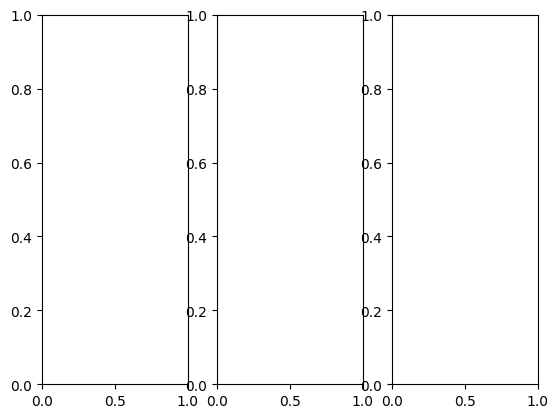

In [35]:
import matplotlib.pyplot as plt

COLS = ["Cycles", "Total ROM", "Total RAM"]

fig, axes = plt.subplots(ncols=len(COLS))
plt.rcParams["figure.figsize"] = (15, 3) # (w, h)


for i, col in enumerate(COLS):
    new_df = report.df[[col]].astype(float)
    new_df.index = MODEL_NAMES
    new_df.plot(kind="bar", ax=axes[i])